In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import warnings
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model as loadModel
from sklearn.metrics import classification_report,confusion_matrix
import joblib

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1252588943659482936
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11330686945635354307
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7021297664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6921974313743632544
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13744885255032289665
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
myDataDir = '../DATA/cell_images'
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(myDataDir) 

['test', 'train']

In [6]:
testPath = myDataDir+'/test/'
trainPath = myDataDir+'/train/'

In [7]:
os.listdir(testPath)

['parasitized', 'uninfected']

In [8]:
os.listdir(trainPath)

['parasitized', 'uninfected']

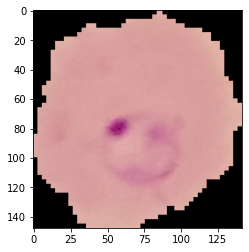

In [9]:
paraCell = trainPath+'parasitized/'+os.listdir(trainPath+'parasitized')[0]
paraimg = imread(paraCell)
plt.imshow(paraimg)

In [10]:
paraimg.shape

(148, 142, 3)

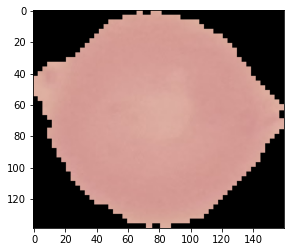

In [11]:
uninfectedCell = trainPath+'uninfected/'+os.listdir(trainPath+'uninfected')[0]
uninfectedimg = imread(uninfectedCell)
plt.imshow(uninfectedimg)

In [12]:
uninfectedimg.shape

(139, 160, 3)

In [13]:
len(os.listdir(trainPath+'/parasitized'))

12480

In [14]:
len(os.listdir(trainPath+'/uninfected'))

12480

In [15]:
len(os.listdir(testPath+'/parasitized'))

1300

In [16]:
len(os.listdir(testPath+'/uninfected'))

1300

# Find average dimensions of images

In [17]:
dim1 = []
dim2 = []
count = 1
for imageFilename in tqdm(os.listdir(testPath+'uninfected')):
    img = imread(testPath+'uninfected'+'/'+imageFilename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)
    count += 1

100%|█████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:06<00:00, 202.10it/s]


C:\Users\NQM\anaconda3\envs\yeet\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


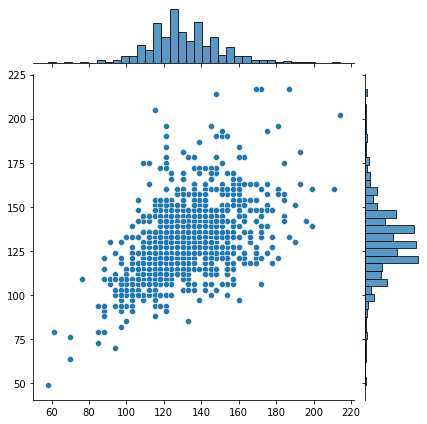

In [18]:
sns.jointplot(dim1,dim2)

In [19]:
np.mean(dim1)

130.92538461538462

In [20]:
np.mean(dim2)

130.75

In [21]:
imageShape = (int(np.mean(dim1)),int(np.mean(dim2)),3)
imageShape

(130, 130, 3)

# Prepare the data

In [22]:
imageGen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               # rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest', # Fill in missing pixels with the nearest filled value
                               dtype = 'float16'
                              )

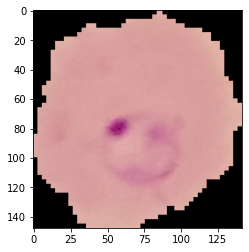

In [23]:
plt.imshow(paraimg)

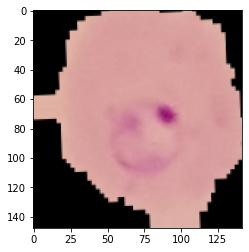

In [24]:
plt.imshow(imageGen.random_transform(paraimg))

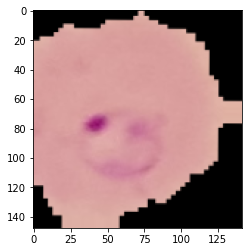

In [25]:
plt.imshow(imageGen.random_transform(paraimg))

**Create model**

In [26]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=imageShape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=imageShape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=imageShape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

earlyStop = EarlyStopping(monitor='val_loss',patience=2)

**Train model**

In [27]:
batchSize = 8

In [28]:
target_size = imageShape[:2]

In [29]:
#If you want to train on different image size, saved to a pickle file, uncomment below

'''target_size = joblib.load("target_size.pkl")
target_size'''

'target_size = joblib.load("target_size.pkl")\ntarget_size'

In [30]:
trainimageGen = imageGen.flow_from_directory(directory = trainPath,
                                               target_size = target_size,
                                                color_mode='rgb',
                                               batch_size=batchSize,
                                               class_mode='binary', shuffle=True)

Found 24958 images belonging to 2 classes.


In [31]:
testimageGen = imageGen.flow_from_directory(directory = testPath,
                                               target_size=target_size,
                                               color_mode='rgb',
                                               batch_size=batchSize,
                                               class_mode='binary', shuffle=False)

Found 2600 images belonging to 2 classes.


In [32]:
trainimageGen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [33]:
warnings.filterwarnings('ignore')

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [35]:
results = model.fit_generator(trainimageGen,epochs=100,
                              validation_data=testimageGen,
                              callbacks=[earlyStop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
3120/3120 [==============================] - 234s 75ms/step - loss: 0.8292 - accuracy: 0.5395 - val_loss: 0.6797 - val_accuracy: 0.5796
Epoch 2/100
3120/3120 [==============================] - 108s 35ms/step - loss: 0.6830 - accuracy: 0.5691 - val_loss: 0.6910 - val_accuracy: 0.5896
Epoch 3/100
3120/3120 [==============================] - 108s 35ms/step - loss: 0.6751 - accuracy: 0.5912 - val_loss: 0.6710 - val_accuracy: 0.5962
Epoch 4/100
3120/3120 [==============================] - 149s 48ms/step - loss: 0.6810 - accuracy: 0.6236 - val_loss: 0.5841 - val_accuracy: 0.7138
Epoch 5/100
3120/3120 [==============================] - 174s 56ms/step - loss: 0.3672 - accuracy: 0.8481 - val_loss: 0.2382 - val_accuracy: 0.9281
Epoch 6/100
3120/3120 [==============================] - 111s 36ms/step - loss: 0.2153 - accuracy: 0.9336 - val_loss: 0.2156 - val_accuracy: 0.9338
Epoch 7/100
3120/3120 [=============

# Evaluate model

In [36]:
#If you want to load pre-trained network
    # 1) comment out the three 'losses' cells below this one
    # 2) uncomment  this cell below  

#model = loadModel('malaria_detectorNQM.h5')

In [37]:
losses = pd.DataFrame(model.history.history)

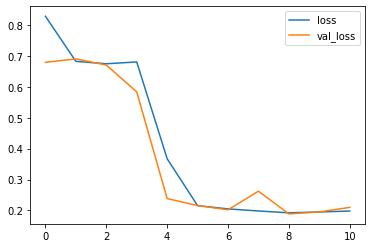

In [38]:
losses[['loss','val_loss']].plot()

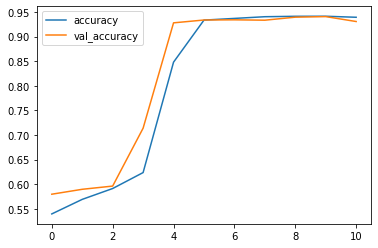

In [39]:
losses[['accuracy','val_accuracy']].plot()

In [40]:
model.metrics_names

['loss', 'accuracy']

In [41]:
model.evaluate_generator(testimageGen)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.22335749864578247, 0.9269230961799622]

In [42]:
predProbabilities = model.predict_generator(testimageGen)

Instructions for updating:
Please use Model.predict, which supports generators.


In [43]:
predProbabilities

array([[5.1133645e-07],
       [3.8529965e-05],
       [1.8613433e-04],
       ...,
       [9.4825125e-01],
       [9.4825125e-01],
       [9.4825125e-01]], dtype=float32)

In [44]:
testimageGen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [45]:
predictions = predProbabilities > 0.5
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [46]:
print(classification_report(testimageGen.classes,predictions))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1300
           1       0.91      0.97      0.94      1300

    accuracy                           0.93      2600
   macro avg       0.94      0.93      0.93      2600
weighted avg       0.94      0.93      0.93      2600



In [47]:
confusion_matrix(testimageGen.classes,predictions)

array([[1171,  129],
       [  42, 1258]], dtype=int64)

# samploe prediction

In [48]:
paraCell

'../DATA/cell_images/train/parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png'

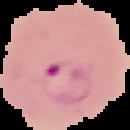

In [49]:
myimage = image.load_img(paraCell,target_size=target_size)
myimage

In [50]:
type(myimage)

PIL.Image.Image

In [51]:
myimage = image.img_to_array(myimage)

In [52]:
type(myimage)

numpy.ndarray

In [53]:
myimage.shape

(130, 130, 3)

In [54]:
myimage = np.expand_dims(myimage, axis=0)
myimage.shape

(1, 130, 130, 3)

In [55]:
model.predict(myimage)

array([[0.00035105]], dtype=float32)

In [56]:
model.predict_classes(myimage)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[0]])

In [57]:
trainimageGen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [58]:
testimageGen.class_indices

{'parasitized': 0, 'uninfected': 1}

# Save model

In [59]:
joblib.dump(imageShape[:2], "target_size.pkl")
model.save('malaria_detectorNQM.h5')

# Deployment Practice

In [60]:
def return_prediction(model, target_size, sample_json):
    imgLoc = sample_json["imgLoc"]
    
    imgData = np.expand_dims(image.img_to_array(image.load_img(imgLoc, target_size = target_size)), axis = 0)
    
    classes = np.array(['parasitized', 'uninfected'])
    
    class_ind = model.predict_classes(imgData)
    
    return classes[class_ind][0][0]

In [61]:
imgLoc = paraCell
cellExample = {'imgLoc' : imgLoc}
return_prediction(model, target_size, cellExample)

'parasitized'

In [62]:
imgLoc = uninfectedCell
cellExample = {'imgLoc' : imgLoc}
return_prediction(model, target_size, cellExample)

'uninfected'